In [26]:
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
import json
from tqdm import tqdm, tqdm_notebook
from colorama import Fore, Style

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(name):
    plt.savefig(f'../../results/figures/{name}.png', bbox_inches='tight', dpi=300)

%reload_ext autoreload
%autoreload 2
    
%reload_ext version_information
%version_information pandas, numpy

Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.4.0
OS Darwin 16.7.0 x86_64 i386 64bit
pandas 0.23.4
numpy 1.16.3
Mon Jun 10 12:20:28 2019 PDT

In [2]:
from dotenv import load_dotenv
load_dotenv('../../.env')

True

# Association Rules

Searching for products that are commonly purchased together.

## Read data

### Read from BigQuery

Same code as `sales_forecast.ipynb`.

In [ ]:
%%time
"""
Using bigquery
"""

from google.cloud import bigquery
# Using environment variables to authenticate
client = bigquery.Client()

def pull_daily_product_sales(verbose=False):
    dataset = client.get_dataset('bigquery-public-data.google_analytics_sample')

    data = []
    for table in tqdm_notebook(list(client.list_tables(dataset))):
        if verbose:
            print('Querying {}'.format(table.table_id))
        query_job = client.query('''
        SELECT
            h.item.productName AS other_purchased_products,
            COUNT(h.item.productName) AS quantity
        FROM `bigquery-public-data.google_analytics_sample.{}`,
            UNNEST(hits) as h
        WHERE (
            fullVisitorId IN (
                SELECT fullVisitorId
                FROM `bigquery-public-data.google_analytics_sample.{}`,
                    UNNEST(hits) as h
                WHERE h.item.productName CONTAINS 'Product Item Name A'
                AND totals.transactions>=1
                GROUP BY fullVisitorId
            )
            AND h.item.productName IS NOT NULL
            AND h.item.productName != 'Product Item Name A'
        )
        GROUP BY other_purchased_products
        ORDER BY quantity DESC;
        '''.format(table.table_id, table.table_id))
        results = query_job.result().to_dataframe()
        results.columns = ['date', 'visits', 'pageviews', 'transactions', 'transactionRevenue']
        data.append(results)

    df = pd.concat(data, ignore_index=True, sort=False)
    return df

bq_product_results = pull_daily_product_sales()

In [ ]:
bq_product_results.head()

In [ ]:
df = bq_product_results.copy()
df.date = pd.to_datetime(df.date)

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'sales_forecast_by_product_raw.csv')
if os.path.isfile(f_path):
    raise Exception(
        'File exists! Run line below in separate cell to overwrite it. '
        'Otherwise just run cell below to load file.')

df.to_csv(f_path, index=False)

### Load pre-queried data

In [3]:
def load_file(f_path):
    if not os.path.exists(f_path):
        print('No data found. Run data load script above.')
        return
    print('Loading {}'.format(f_path))
    df = pd.read_csv(f_path)
    df.date = pd.to_datetime(df.date)
    return df

f_path = os.path.join(os.getenv('DATA_PATH'), 'interim', 'sales_forecast_by_product_raw.csv')
df = load_file(f_path)

Loading /Volumes/GoogleDrive/My Drive/ga-data-mining/data/interim/sales_forecast_by_product_raw.csv


In [4]:
df.head()

,date,visitId,fullVisitorId,productSKU,v2ProductName,productVariant,productRevenue,productQuantity,productRefundAmount
0,2016-08-01,1470106850,4993485206334150199,GGOEYAAQ031714,YouTube Men's Short Sleeve Hero Tee White,MD,23990000,1,NaN
1,2016-08-01,1470084579,3907770685196037697,GGOEYDHJ019399,24 oz YouTube Sergeant Stripe Bottle,Single Option Only,12990000,1,NaN
2,2016-08-01,1470069291,7056870819058799369,GGOEGAAQ010417,Google Men's 100% Cotton Short Sleeve Hero Tee...,2XL,22590000,1,NaN
3,2016-08-01,1470096817,6030957980134486247,GGOEYAEB028413,Women's YouTube Short Sleeve Hero Tee Black,SM,19990000,1,NaN
4,2016-08-01,1470055898,6203401114057579951,GGOEGDHC018299,22 oz Mini Mountain Bottle,BLUE,36350000,15,NaN


[source -> support.google.com](https://support.google.com/analytics/answer/3437719?hl=en)

> **visitId**   
An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.

In [5]:
df['visitId'].nunique()

11548

In [6]:
df['fullVisitorId'].nunique()

10021

In [7]:
df['transactionId'] = df['visitId'].astype(str) + '|' + df['fullVisitorId'].astype(str)
df['transactionId'].nunique()

11550

In [8]:
df['fullProductName'] = ''

# Do not include product variants for "Single Option Only"
m = df['productVariant'] == 'Single Option Only'
df.loc[m, 'fullProductName'] = df.loc[m, 'v2ProductName'].str.strip()
df.loc[~m, 'fullProductName'] = (
    df.loc[~m, 'v2ProductName'].str.strip()
    + ' ('
    + df.loc[~m, 'productVariant'].str.strip()
    + ')'
)

In [9]:
df_itemsets_by_transaction = df.groupby('transactionId')['fullProductName'].apply(list).to_frame()

In [10]:
df_itemsets_by_user = df.groupby('fullVisitorId')['fullProductName'].apply(list).to_frame()

In [11]:
pd.options.display.max_colwidth = 1000

Some transactions with multiple items:

In [12]:
df_itemsets_by_transaction[df_itemsets_by_transaction.fullProductName.apply(lambda x: len(x) > 1)].head()

,fullProductName
transactionId,
1470046365|4166700707688517424,"[Women's YouTube Short Sleeve Hero Tee Black (MD), YouTube Men's Short Sleeve Hero Tee Charcoal (MD), YouTube Men's Short Sleeve Hero Tee Charcoal (XL), UFO Bluetooth Water Resistant Speaker]"
1470055898|6203401114057579951,"[22 oz Mini Mountain Bottle (BLUE), 22 oz Mini Mountain Bottle (RED)]"
1470057237|3213840074316400693,"[Color Changing Grip Pen, Kick Ball, Electronics Accessory Pouch, Badge Holder]"
1470063041|6485652672428047343,"[Red Spiral Google Notebook, Electronics Accessory Pouch, Google Sunglasses (GREEN), Google Sunglasses (BLUE), Recycled Mouse Pad]"
1470063685|6997692197808690953,"[Android Toddler Short Sleeve T-shirt Pink (5/6T), Google Toddler Short Sleeve T-shirt Grey (5/6T), 24 oz USA Made Aluminum Bottle, Blue Metallic Textured Spiral Notebook Set]"


Set up non-variant dataset as well

In [13]:
df_itemsets_by_transaction_no_variants = df.groupby('transactionId')['v2ProductName'].apply(list).to_frame()
df_itemsets_by_transaction_no_variants['v2ProductName'] = df_itemsets_by_transaction_no_variants.v2ProductName.apply(lambda x: list(set(x)))
m = df_itemsets_by_transaction_no_variants.v2ProductName.apply(len) > 1
df_itemsets_by_transaction_no_variants = df_itemsets_by_transaction_no_variants[m].copy()

In [14]:
df_itemsets_by_transaction_no_variants[df_itemsets_by_transaction_no_variants.v2ProductName.apply(lambda x: len(x) > 1)].head()


,v2ProductName
transactionId,
1470046365|4166700707688517424,"[UFO Bluetooth Water Resistant Speaker, Women's YouTube Short Sleeve Hero Tee Black, YouTube Men's Short Sleeve Hero Tee Charcoal]"
1470057237|3213840074316400693,"[Electronics Accessory Pouch, Badge Holder, Color Changing Grip Pen, Kick Ball]"
1470063041|6485652672428047343,"[Electronics Accessory Pouch, Red Spiral Google Notebook, Google Sunglasses, Recycled Mouse Pad]"
1470063685|6997692197808690953,"[24 oz USA Made Aluminum Bottle, Google Toddler Short Sleeve T-shirt Grey, Android Toddler Short Sleeve T-shirt Pink, Blue Metallic Textured Spiral Notebook Set]"
1470064251|3006489767948351126,"[Android 24 oz Contigo Addison, Google Men's 100% Cotton Short Sleeve Hero Tee White, Engraved Ceramic Google Mug, 26 oz Double Wall Insulated Bottle, Android Rise 14 oz Mug]"


## Finding Association Rules

### Frequent itemsets (including product variants)

In [15]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [16]:
TransactionEncoder?

In [17]:
transactions = df_itemsets_by_transaction['fullProductName'].tolist()

In [18]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

In [19]:
df_te.head()

,1 oz Hand Sanitizer,16 oz. Hot and Cold Tumbler,16 oz. Hot/Cold Tumbler,20 oz Stainless Steel Insulated Tumbler,22 oz Android Bottle,22 oz Mini Mountain Bottle (BLUE),22 oz Mini Mountain Bottle (RED),22 oz YouTube Bottle Infuser,23 oz Wide Mouth Sport Bottle,24 oz USA Made Aluminum Bottle,...,YouTube Women's Short Sleeve Tri-blend Badge Tee Grey (XL),YouTube Womens 3/4 Sleeve Baseball Raglan White/Black (LG),YouTube Womens 3/4 Sleeve Baseball Raglan White/Black (MD),YouTube Womens 3/4 Sleeve Baseball Raglan White/Black (SM),YouTube Womens 3/4 Sleeve Baseball Raglan White/Black (XL),YouTube Wool Heather Cap Heather/Black,YouTube Youth Short Sleeve Tee Red (10/12 Y),YouTube Youth Short Sleeve Tee Red (14/16 Y),YouTube Youth Short Sleeve Tee Red (7 Y),YouTube Youth Short Sleeve Tee Red (8/10 Y)
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
frequent_itemsets = apriori(df_te, min_support=0.001, use_colnames=True)

[source -> mlxtend docs](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/#association-rules-generation-from-frequent-itemsets)

> Typically, support is used to measure the abundance or frequency (often interpreted as significance or importance) of an itemset in a database

In [21]:
frequent_itemsets.sort_values('support', ascending=False).head(10)

,support,itemsets
177,0.067706,(Google Laptop and Cell Phone Stickers)
121,0.040606,(Google 22 oz Water Bottle (BLUE))
341,0.037403,(Google Sunglasses (BLUE))
370,0.034026,(Google Twill Cap)
12,0.033680,(26 oz Double Wall Insulated Bottle)
109,0.032900,(Engraved Ceramic Google Mug)
507,0.030043,(Red Shine 15 oz Mug)
539,0.029784,(YouTube Custom Decals)
504,0.029264,(Recycled Mouse Pad)
343,0.029177,(Google Sunglasses (RED))


In [22]:
(frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)]
     .sort_values('support', ascending=False).head(10))

,support,itemsets
1349,0.022511,"(Google Sunglasses (BLUE), Google Sunglasses (RED))"
1348,0.020866,"(Google Sunglasses (BLUE), Google Sunglasses (GREEN))"
1350,0.019134,"(Google Sunglasses (BLUE), Google Sunglasses (YELLOW))"
1369,0.018355,"(Google Sunglasses (GREEN), Google Sunglasses (RED))"
1092,0.017835,"(Google 22 oz Water Bottle (BLUE), Google 22 oz Water Bottle (RED))"
1370,0.017489,"(Google Sunglasses (YELLOW), Google Sunglasses (GREEN))"
1383,0.017403,"(Google Sunglasses (YELLOW), Google Sunglasses (RED))"
1716,0.017229,"(Google Sunglasses (BLUE), Google Sunglasses (GREEN), Google Sunglasses (RED))"
1724,0.016623,"(Google Sunglasses (BLUE), Google Sunglasses (YELLOW), Google Sunglasses (RED))"
1717,0.016104,"(Google Sunglasses (BLUE), Google Sunglasses (YELLOW), Google Sunglasses (GREEN))"


In [24]:
from itertools import combinations

Support for pairs of sunglasses in transactions:


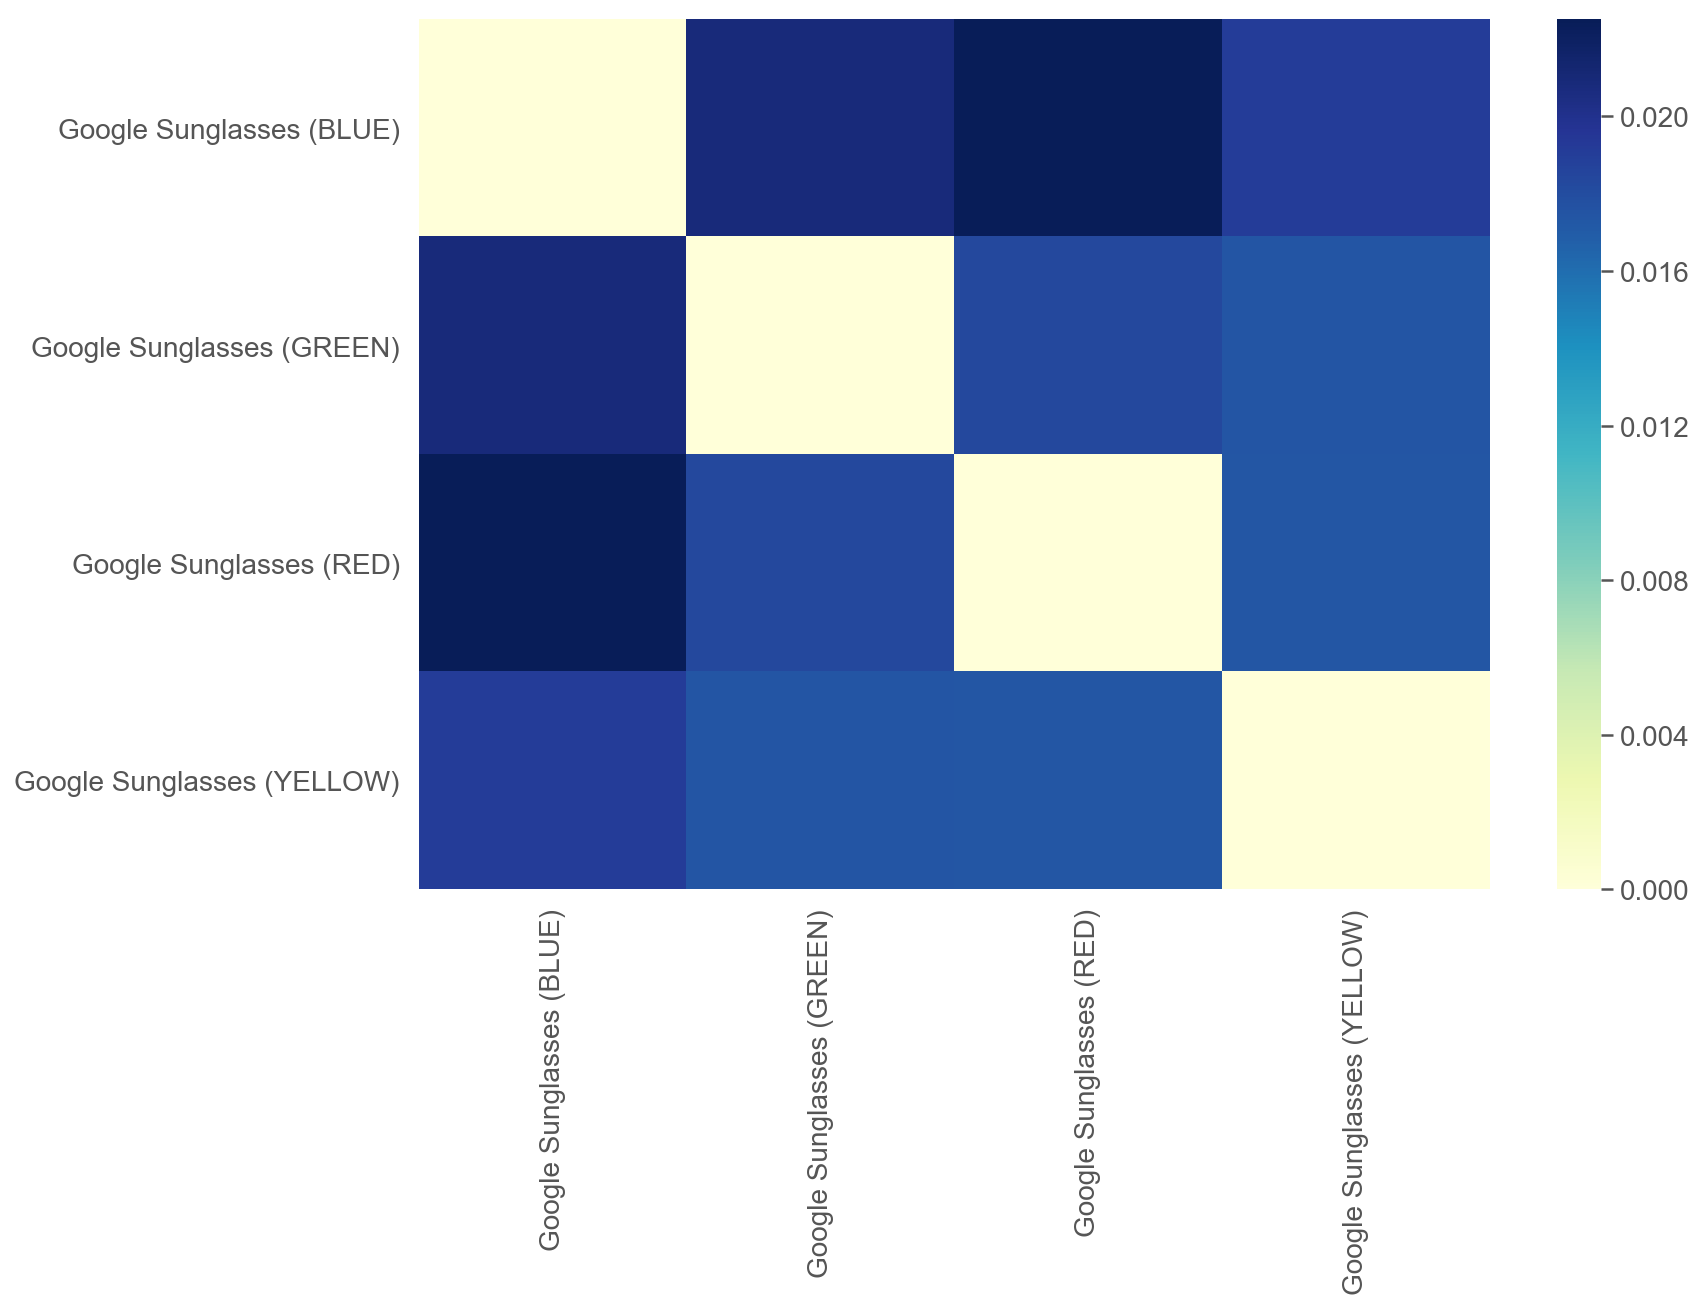

In [27]:
m = (
    (frequent_itemsets.itemsets.apply(len) == 2)
    & (frequent_itemsets.itemsets.apply(lambda x: all(('Sunglasses' in _x for _x in x))))
)
data_1 = frequent_itemsets[m].copy()
data_2 = frequent_itemsets[m].copy()
data_1['item_1'] = data_1.itemsets.apply(lambda x: list(x)[0])
data_1['item_2'] = data_1.itemsets.apply(lambda x: list(x)[1])
data_2['item_1'] = data_2.itemsets.apply(lambda x: list(x)[1])
data_2['item_2'] = data_2.itemsets.apply(lambda x: list(x)[0])
data = pd.concat((data_1, data_2))

data_zeros = pd.DataFrame([[0, ''] + list(x) for x in combinations(data[['item_1', 'item_2']].values.flatten(), 2)], columns=data.columns)
data = pd.concat((data, data_zeros)).groupby(['item_1', 'item_2']).support.sum().reset_index().pivot('item_1', 'item_2', 'support')

print('Support for pairs of sunglasses in transactions:')

sns.heatmap(data, cmap='YlGnBu')
plt.xlabel('')
plt.ylabel('')
savefig('association_rules_frequent_sunglasses_combinations')

How about stuff that doesn't include sunglasses ;)

In [28]:
(frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)
                    & (~(frequent_itemsets.itemsets.astype(str).str.contains('Sunglasses')))]
     .sort_values('support', ascending=False).head(10))

,support,itemsets
1092,0.017835,"(Google 22 oz Water Bottle (BLUE), Google 22 oz Water Bottle (RED))"
1465,0.009784,"(Recycled Paper Journal Set (BLUE), Recycled Paper Journal Set (RED))"
758,0.009351,"(Google Laptop and Cell Phone Stickers, Android Sticker Sheet Ultra Removable)"
1257,0.008918,"(Google Laptop and Cell Phone Stickers, YouTube Custom Decals)"
1185,0.008052,"(Google Laptop and Cell Phone Stickers, Google Doodle Decal)"
727,0.007706,"(Google Laptop and Cell Phone Stickers, 8 pc Android Sticker Sheet)"
1099,0.007013,"(Google Laptop and Cell Phone Stickers, Google 22 oz Water Bottle (BLUE))"
1243,0.007013,"(Google Laptop and Cell Phone Stickers, Recycled Mouse Pad)"
1240,0.007013,"(Maze Pen, Google Laptop and Cell Phone Stickers)"
1238,0.006667,"(Google Laptop and Cell Phone Stickers, Keyboard DOT Sticker)"


Support for top pairs of items:


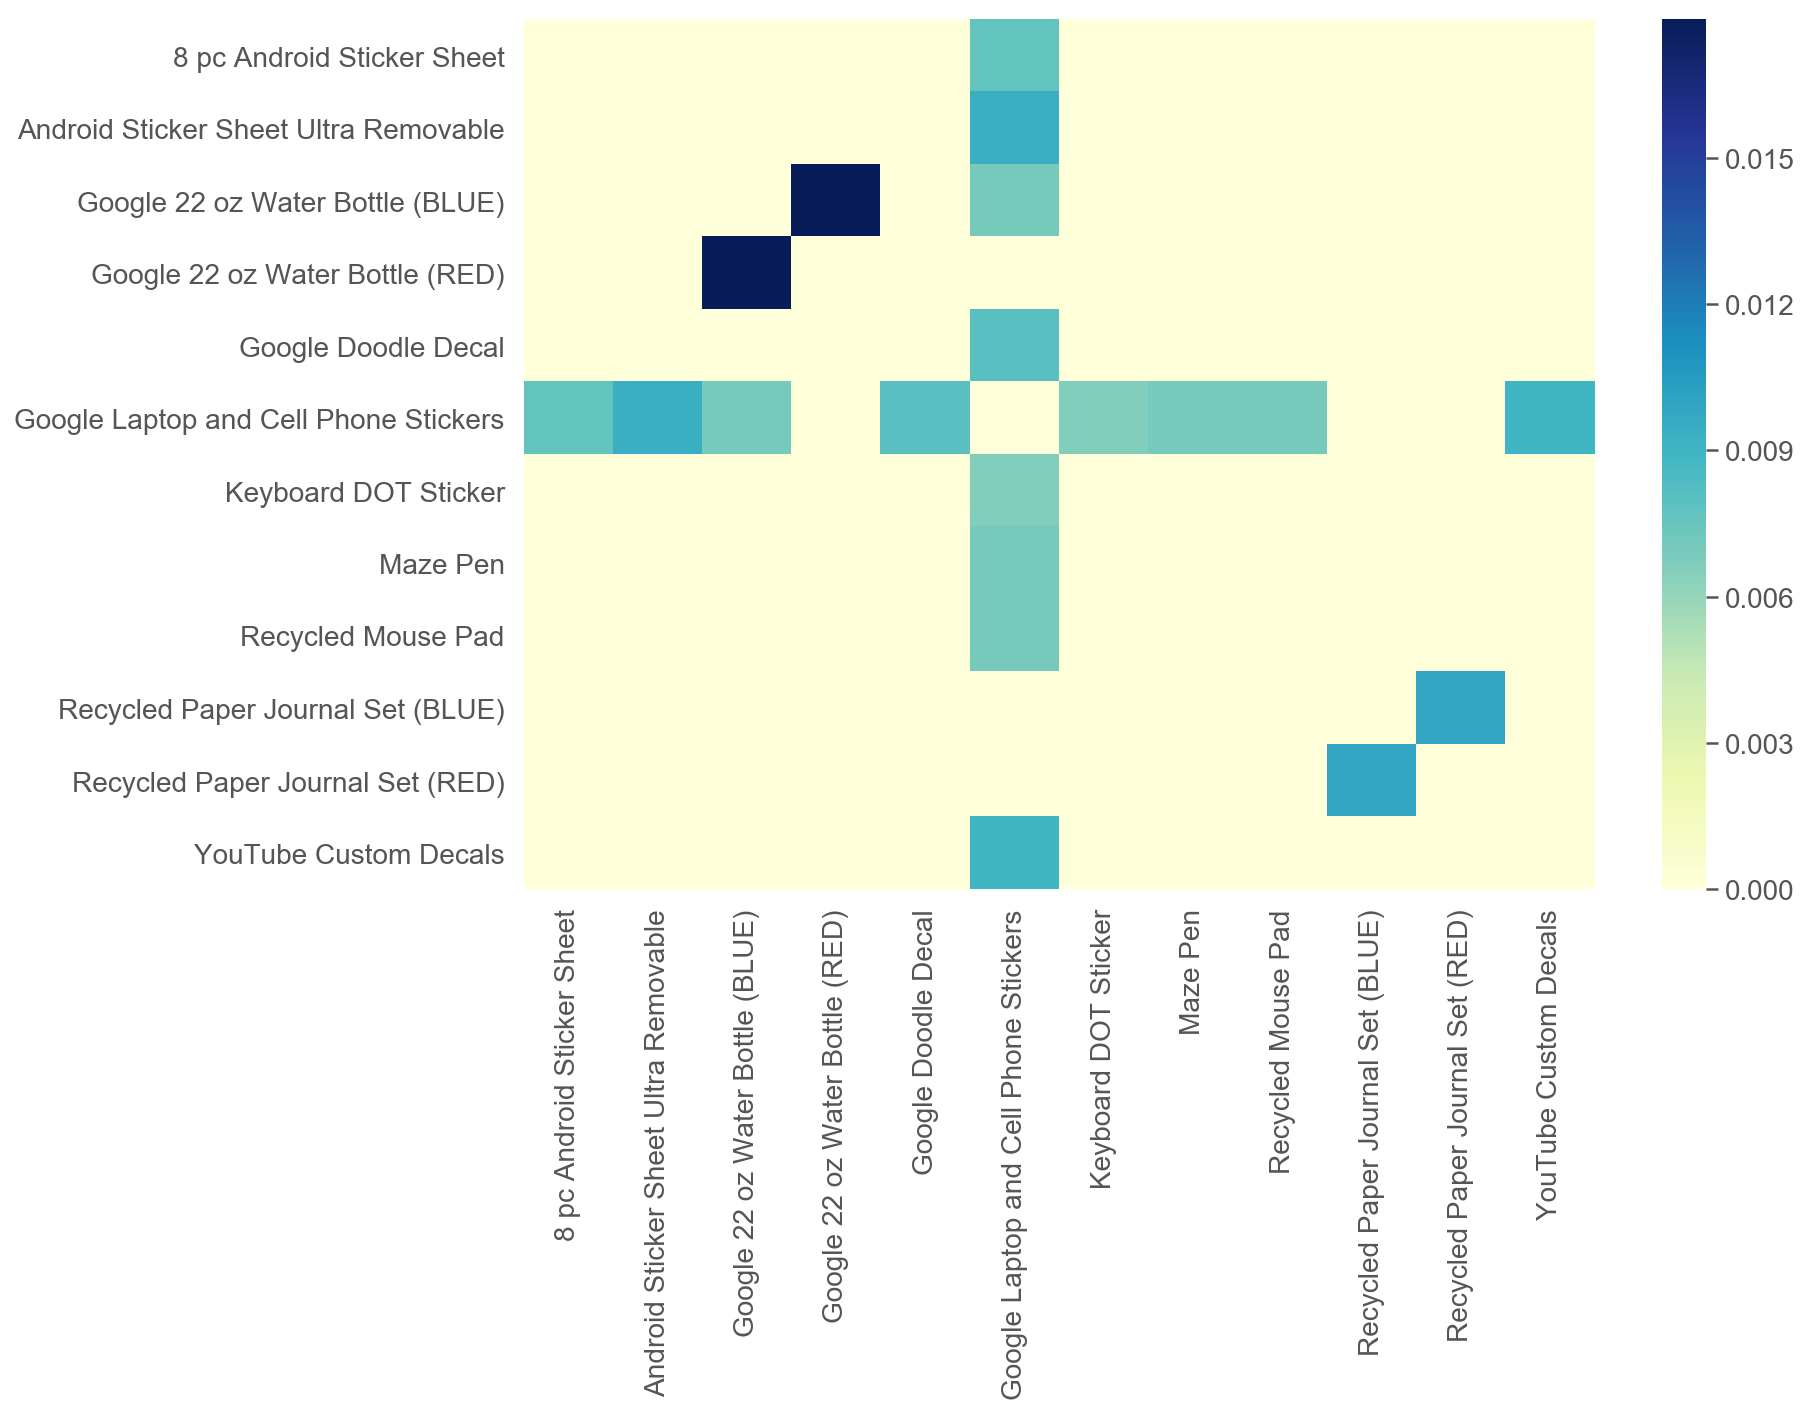

In [29]:
most_frequent_itemsets = (frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)
                    & (~(frequent_itemsets.itemsets.astype(str).str.contains('Sunglasses')))]
                     .sort_values('support', ascending=False).head(10))

data_1 = most_frequent_itemsets.copy()
data_2 = most_frequent_itemsets.copy()
data_1['item_1'] = data_1.itemsets.apply(lambda x: list(x)[0])
data_1['item_2'] = data_1.itemsets.apply(lambda x: list(x)[1])
data_2['item_1'] = data_2.itemsets.apply(lambda x: list(x)[1])
data_2['item_2'] = data_2.itemsets.apply(lambda x: list(x)[0])
data = pd.concat((data_1, data_2))

data_zeros = pd.DataFrame([[0, ''] + list(x) for x in combinations(data[['item_1', 'item_2']].values.flatten(), 2)], columns=data.columns)
data = pd.concat((data, data_zeros)).groupby(['item_1', 'item_2']).support.sum().reset_index().pivot('item_1', 'item_2', 'support')

print('Support for top pairs of items:')

sns.heatmap(data, cmap='YlGnBu')
plt.xlabel('')
plt.ylabel('')
savefig('association_rules_frequent_item_combinations_10_including_variations')


Support for top pairs of items:


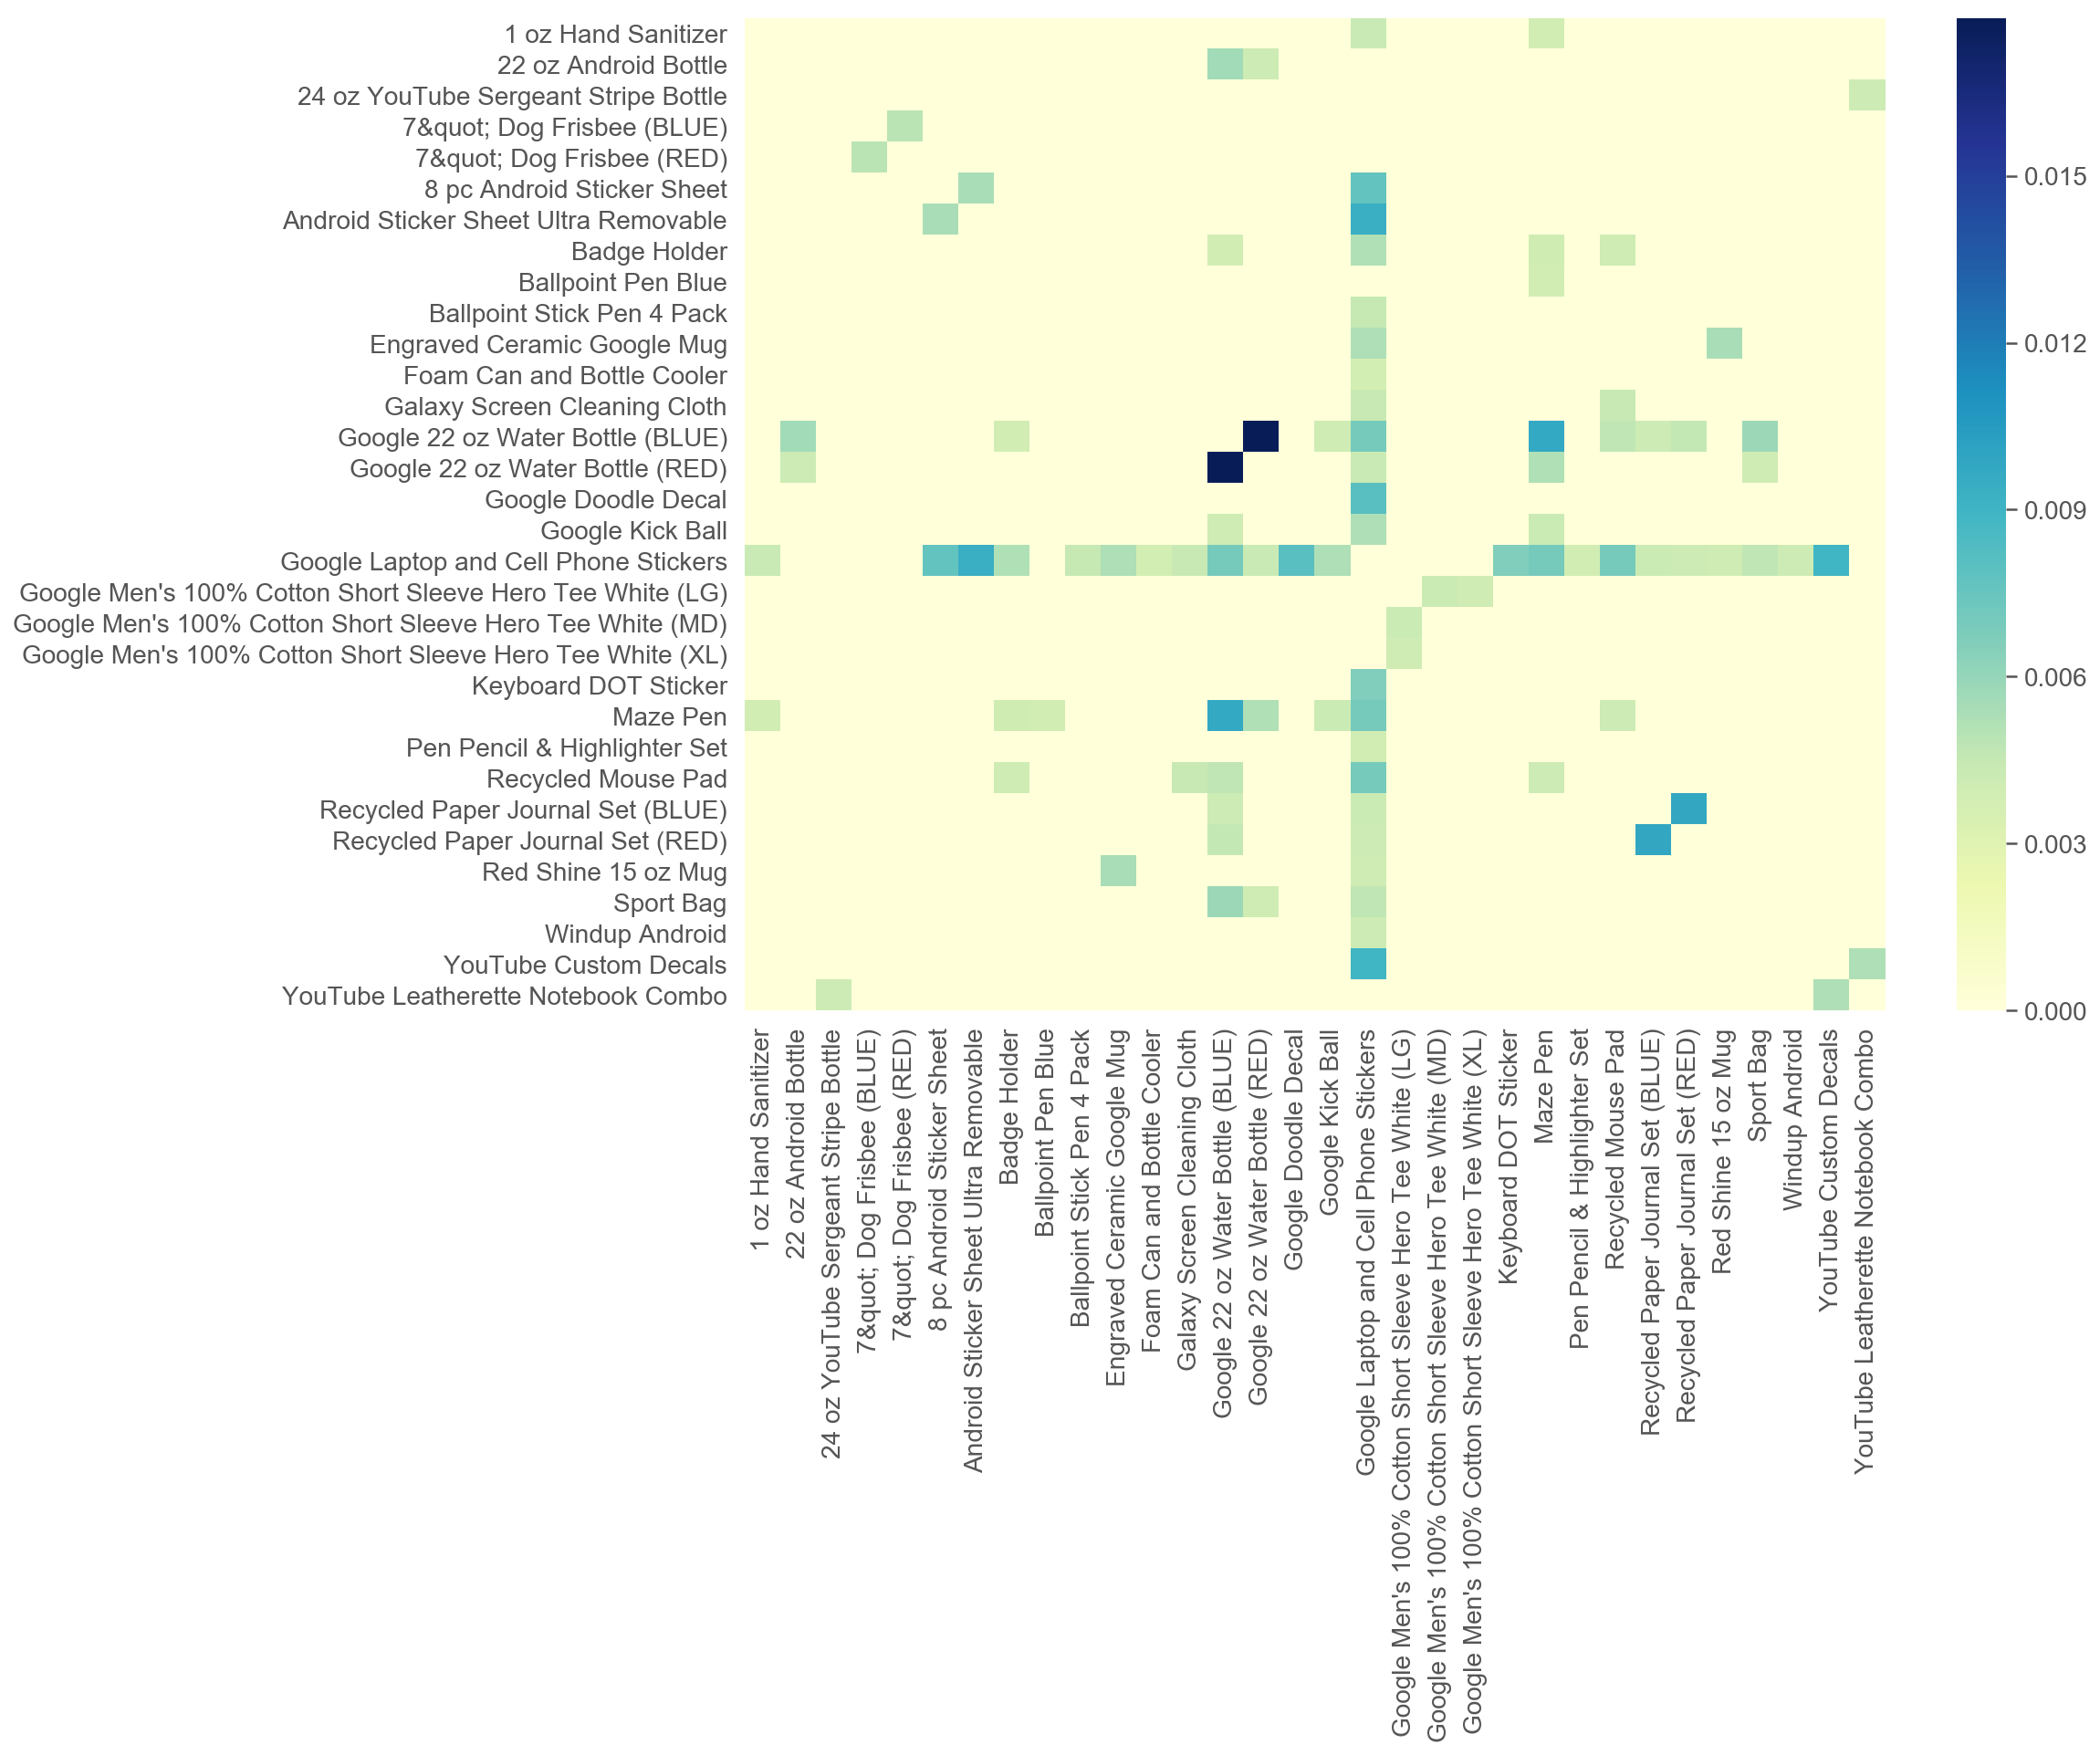

In [30]:
plt.figure(figsize=(14, 10))

most_frequent_itemsets = (frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)
                    & (~(frequent_itemsets.itemsets.astype(str).str.contains('Sunglasses')))]
                     .sort_values('support', ascending=False).head(50))

data_1 = most_frequent_itemsets.copy()
data_2 = most_frequent_itemsets.copy()
data_1['item_1'] = data_1.itemsets.apply(lambda x: list(x)[0])
data_1['item_2'] = data_1.itemsets.apply(lambda x: list(x)[1])
data_2['item_1'] = data_2.itemsets.apply(lambda x: list(x)[1])
data_2['item_2'] = data_2.itemsets.apply(lambda x: list(x)[0])
data = pd.concat((data_1, data_2))

data_zeros = pd.DataFrame([[0, ''] + list(x) for x in combinations(data[['item_1', 'item_2']].values.flatten(), 2)], columns=data.columns)
data = pd.concat((data, data_zeros)).groupby(['item_1', 'item_2']).support.sum().reset_index().pivot('item_1', 'item_2', 'support')

print('Support for top pairs of items:')

sns.heatmap(data, cmap='YlGnBu')
plt.xlabel('')
plt.ylabel('')
savefig('association_rules_frequent_item_combinations_50_including_variations')


Notice how laptop stickers are a common add-on item for a large variety of other products.

### Association rules (including product variants)

Mining association rules from item sets. Note:

[source -> mlxtend docs](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/#association-rules-generation-from-frequent-itemsets)

> The confidence of a rule A->C is the probability of seeing the consequent in a transaction given that it also contains the antecedent

In [31]:
rules = association_rules(frequent_itemsets)

In [32]:
rules.sort_values('confidence', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
116,"(Google Sunglasses (BLUE), Engraved Ceramic Google Mug, Google Sunglasses (YELLOW))",(Google Sunglasses (GREEN)),0.001212,0.027446,0.001212,1.0,36.435331,0.001179,inf
262,"(Google Sunglasses (YELLOW), Google Sunglasses (GREEN), Google Kick Ball, Google Sunglasses (RED))",(Google Sunglasses (BLUE)),0.001385,0.037403,0.001385,1.0,26.736111,0.001333,inf
161,"(Google Doodle Decal, Google Sunglasses (YELLOW), Google Sunglasses (RED))",(Google Sunglasses (BLUE)),0.001039,0.037403,0.001039,1.0,26.736111,0.001000,inf
199,"(Google Sunglasses (GREEN), Sport Bag, Google Sunglasses (RED))",(Google Sunglasses (BLUE)),0.001472,0.037403,0.001472,1.0,26.736111,0.001417,inf
197,"(Google Sunglasses (GREEN), Google Sunglasses (RED), Recycled Mouse Pad)",(Google Sunglasses (BLUE)),0.001299,0.037403,0.001299,1.0,26.736111,0.001250,inf


Loads of these have high confidence, but they are not very frequent (low support).

Given the nature of this dataset, I think it's better to sort by `support`

In [33]:
rules.sort_values('antecedent support', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(Google Sunglasses (YELLOW)),(Google Sunglasses (BLUE)),0.022338,0.037403,0.019134,0.856589,22.901863,0.018299,6.712166
64,"(Google Sunglasses (BLUE), Google Sunglasses (GREEN))",(Google Sunglasses (RED)),0.020866,0.029177,0.017229,0.825726,28.300110,0.016621,5.570672
72,"(Google Sunglasses (BLUE), Google Sunglasses (YELLOW))",(Google Sunglasses (RED)),0.019134,0.029177,0.016623,0.868778,29.775635,0.016065,7.398337
66,"(Google Sunglasses (BLUE), Google Sunglasses (YELLOW))",(Google Sunglasses (GREEN)),0.019134,0.027446,0.016104,0.841629,30.665030,0.015579,6.140985
65,"(Google Sunglasses (GREEN), Google Sunglasses (RED))",(Google Sunglasses (BLUE)),0.018355,0.037403,0.017229,0.938679,25.096633,0.016543,15.697742
87,"(Google Sunglasses (GREEN), Google Sunglasses (RED))",(Google Sunglasses (YELLOW)),0.018355,0.022338,0.015238,0.830189,37.165423,0.014828,5.757345
194,"(Google Sunglasses (GREEN), Google Sunglasses (RED))","(Google Sunglasses (BLUE), Google Sunglasses (YELLOW))",0.018355,0.019134,0.014719,0.801887,41.908563,0.014367,4.951037
67,"(Google Sunglasses (YELLOW), Google Sunglasses (GREEN))",(Google Sunglasses (BLUE)),0.017489,0.037403,0.016104,0.920792,24.618399,0.015450,12.152792
192,"(Google Sunglasses (YELLOW), Google Sunglasses (GREEN))","(Google Sunglasses (BLUE), Google Sunglasses (RED))",0.017489,0.022511,0.014719,0.841584,37.385758,0.014325,6.170400
85,"(Google Sunglasses (YELLOW), Google Sunglasses (GREEN))",(Google Sunglasses (RED)),0.017489,0.029177,0.015238,0.871287,29.861621,0.014728,7.542544


In [34]:
m_yellow_sunglasses = df_itemsets_by_transaction.fullProductName.apply(lambda x: 'Google Sunglasses (YELLOW)' in x)
m_blue_sunglasses = df_itemsets_by_transaction.fullProductName.apply(lambda x: 'Google Sunglasses (BLUE)' in x)
m_y_and_b_sunglasses = df_itemsets_by_transaction.fullProductName.apply(lambda x: 'Google Sunglasses (YELLOW)' in x and 'Google Sunglasses (BLUE)' in x)

In [35]:
print('{} transactions with yellow sunglasses'.format(m_yellow_sunglasses.sum()))
print('{} transactions with blue sunglasses'.format(m_blue_sunglasses.sum()))
print('{} transactions with both'.format(m_y_and_b_sunglasses.sum()))
print('> {:.0f}% of yellow orders have blue'.format(m_y_and_b_sunglasses.sum() / m_yellow_sunglasses.sum() * 100))
print('> {:.0f}% of blue orders have yellow'.format(m_y_and_b_sunglasses.sum() / m_blue_sunglasses.sum() * 100))

258 transactions with yellow sunglasses
432 transactions with blue sunglasses
221 transactions with both
> 86% of yellow orders have blue
> 51% of blue orders have yellow


This can be used as the basis for a recommendation engine, or to inform marketing and product design decisions.

Ignoring the sunglasses...

In [36]:
m_no_sunglasses = (~(rules.antecedents.astype(str).str.contains('Sunglasses'))) & (~(rules.consequents.astype(str).str.contains('Sunglasses')))
rules[m_no_sunglasses].sort_values('antecedent support', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
23,"(Android Sticker Sheet Ultra Removable, YouTube Custom Decals)",(Google Laptop and Cell Phone Stickers),0.002771,0.067706,0.002424,0.875000,12.923593,0.002237,7.458355
148,"(Google 22 oz Water Bottle (BLUE), Recycled Paper Journal Set (RED), Google 22 oz Water Bottle (RED))",(Recycled Paper Journal Set (BLUE)),0.002771,0.017835,0.002251,0.812500,45.555218,0.002202,5.238211
62,"(Google Men's 100% Cotton Short Sleeve Hero Tee White (MD), Google Men's 100% Cotton Short Sleeve Hero Tee White (XL))",(Google Men's 100% Cotton Short Sleeve Hero Tee White (LG)),0.002771,0.020260,0.002251,0.812500,40.104167,0.002195,5.225281
58,"(Google Men's 100% Cotton Short Sleeve Hero Tee Black (XL), Google Men's 100% Cotton Short Sleeve Hero Tee Black (MD))",(Google Men's 100% Cotton Short Sleeve Hero Tee Black (LG)),0.002597,0.017403,0.002165,0.833333,47.885572,0.002119,5.895584
146,"(Recycled Paper Journal Set (BLUE), Google 22 oz Water Bottle (BLUE), Google 22 oz Water Bottle (RED))",(Recycled Paper Journal Set (RED)),0.002511,0.018182,0.002251,0.896552,49.310345,0.002205,9.490909
28,"(Badge Holder, Google 22 oz Water Bottle (RED))",(Google 22 oz Water Bottle (BLUE)),0.002338,0.040606,0.001991,0.851852,20.978441,0.001896,6.475909
11,"(7&quot; Dog Frisbee (BLUE), Google Kick Ball)",(7&quot; Dog Frisbee (RED)),0.002338,0.007965,0.001905,0.814815,102.294686,0.001886,5.356987
147,"(Recycled Paper Journal Set (BLUE), Recycled Paper Journal Set (RED), Google 22 oz Water Bottle (RED))",(Google 22 oz Water Bottle (BLUE)),0.002251,0.040606,0.002251,1.000000,24.626866,0.002160,inf
0,(22 oz Mini Mountain Bottle (RED)),(22 oz Mini Mountain Bottle (BLUE)),0.001905,0.002857,0.001558,0.818182,286.363636,0.001553,5.484286
54,"(Google Men's 100% Cotton Short Sleeve Hero Tee Black (MD), Google Men's 100% Cotton Short Sleeve Hero Tee Black (2XL))",(Google Men's 100% Cotton Short Sleeve Hero Tee Black (LG)),0.001818,0.017403,0.001472,0.809524,46.517413,0.001440,5.158636


In [37]:
rules['rule'] = rules.antecedents.apply(list).astype(str) + '  ->  ' + rules.consequents.apply(list).astype(str)

In [38]:
s = (
    rules[m_no_sunglasses].sort_values('support', ascending=False)
         .head(10)[['rule', 'support', 'confidence']]
         .style
)
s.bar(subset=['support', 'confidence'], color='#6670ff')

,rule,support,confidence
23,"['Android Sticker Sheet Ultra Removable', 'YouTube Custom Decals'] -> ['Google Laptop and Cell Phone Stickers']",0.00242424,0.875
62,"[""Google Men's 100% Cotton Short Sleeve Hero Tee White (MD)"", ""Google Men's 100% Cotton Short Sleeve Hero Tee White (XL)""] -> [""Google Men's 100% Cotton Short Sleeve Hero Tee White (LG)""]",0.00225108,0.8125
146,"['Recycled Paper Journal Set (BLUE)', 'Google 22 oz Water Bottle (BLUE)', 'Google 22 oz Water Bottle (RED)'] -> ['Recycled Paper Journal Set (RED)']",0.00225108,0.896552
148,"['Google 22 oz Water Bottle (BLUE)', 'Recycled Paper Journal Set (RED)', 'Google 22 oz Water Bottle (RED)'] -> ['Recycled Paper Journal Set (BLUE)']",0.00225108,0.8125
147,"['Recycled Paper Journal Set (BLUE)', 'Recycled Paper Journal Set (RED)', 'Google 22 oz Water Bottle (RED)'] -> ['Google 22 oz Water Bottle (BLUE)']",0.00225108,1
58,"[""Google Men's 100% Cotton Short Sleeve Hero Tee Black (XL)"", ""Google Men's 100% Cotton Short Sleeve Hero Tee Black (MD)""] -> [""Google Men's 100% Cotton Short Sleeve Hero Tee Black (LG)""]",0.0021645,0.833333
28,"['Badge Holder', 'Google 22 oz Water Bottle (RED)'] -> ['Google 22 oz Water Bottle (BLUE)']",0.00199134,0.851852
11,"['7"" Dog Frisbee (BLUE)', 'Google Kick Ball'] -> ['7"" Dog Frisbee (RED)']",0.00190476,0.814815
0,['22 oz Mini Mountain Bottle (RED)'] -> ['22 oz Mini Mountain Bottle (BLUE)'],0.00155844,0.818182
40,"['Rocket Flashlight', 'Google 22 oz Water Bottle (RED)'] -> ['Google 22 oz Water Bottle (BLUE)']",0.00147186,0.894737


### Frequent items & association rules (excluding product variants)

In [39]:
df_itemsets_by_transaction_no_variants.head()

,v2ProductName
transactionId,
1470046365|4166700707688517424,"[UFO Bluetooth Water Resistant Speaker, Women's YouTube Short Sleeve Hero Tee Black, YouTube Men's Short Sleeve Hero Tee Charcoal]"
1470057237|3213840074316400693,"[Electronics Accessory Pouch, Badge Holder, Color Changing Grip Pen, Kick Ball]"
1470063041|6485652672428047343,"[Electronics Accessory Pouch, Red Spiral Google Notebook, Google Sunglasses, Recycled Mouse Pad]"
1470063685|6997692197808690953,"[24 oz USA Made Aluminum Bottle, Google Toddler Short Sleeve T-shirt Grey, Android Toddler Short Sleeve T-shirt Pink, Blue Metallic Textured Spiral Notebook Set]"
1470064251|3006489767948351126,"[Android 24 oz Contigo Addison, Google Men's 100% Cotton Short Sleeve Hero Tee White, Engraved Ceramic Google Mug, 26 oz Double Wall Insulated Bottle, Android Rise 14 oz Mug]"


In [40]:
transactions = df_itemsets_by_transaction_no_variants['v2ProductName'].tolist()

In [41]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

In [42]:
df_te.head()

,1 oz Hand Sanitizer,16 oz. Hot and Cold Tumbler,16 oz. Hot/Cold Tumbler,20 oz Stainless Steel Insulated Tumbler,22 oz Android Bottle,22 oz Mini Mountain Bottle,22 oz YouTube Bottle Infuser,23 oz Wide Mouth Sport Bottle,24 oz USA Made Aluminum Bottle,24 oz YouTube Sergeant Stripe Bottle,...,YouTube Women's Fleece Hoodie Black,YouTube Women's Racer Back Tank Black,YouTube Women's S/S Crew Tee,YouTube Women's Short Sleeve Crew Tee,YouTube Women's Short Sleeve Hero Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Grey,YouTube Womens 3/4 Sleeve Baseball Raglan White/Black,YouTube Wool Heather Cap Heather/Black,YouTube Youth Short Sleeve Tee Red
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [43]:
frequent_itemsets = apriori(df_te, min_support=0.001, use_colnames=True)

[source -> mlxtend docs](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/#association-rules-generation-from-frequent-itemsets)

> Typically, support is used to measure the abundance or frequency (often interpreted as significance or importance) of an itemset in a database

In [44]:
frequent_itemsets.sort_values('support', ascending=False).head(10)

,support,itemsets
148,0.107326,(Google Laptop and Cell Phone Stickers)
102,0.071978,(Google 22 oz Water Bottle)
220,0.071408,(Google Sunglasses)
156,0.065279,(Google Men's 100% Cotton Short Sleeve Hero Tee Black)
159,0.065137,(Google Men's 100% Cotton Short Sleeve Hero Tee White)
157,0.060006,(Google Men's 100% Cotton Short Sleeve Hero Tee Navy)
92,0.047605,(Engraved Ceramic Google Mug)
319,0.044612,(Recycled Mouse Pad)
355,0.044327,(YouTube Custom Decals)
235,0.044042,(Google Twill Cap)


In [45]:
(frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)]
     .sort_values('support', ascending=False).head(10))

,support,itemsets
727,0.015393,"(Google Laptop and Cell Phone Stickers, Android Sticker Sheet Ultra Removable)"
1509,0.014681,"(Google Laptop and Cell Phone Stickers, YouTube Custom Decals)"
1545,0.013826,"(Google Men's 100% Cotton Short Sleeve Hero Tee Black, Google Men's 100% Cotton Short Sleeve Hero Tee Navy)"
1276,0.013398,"(Google Sunglasses, Google 22 oz Water Bottle)"
1390,0.013255,"(Google Laptop and Cell Phone Stickers, Google Doodle Decal)"
1260,0.013113,"(Google Laptop and Cell Phone Stickers, Google 22 oz Water Bottle)"
1478,0.012828,"(Google Laptop and Cell Phone Stickers, Google Sunglasses)"
632,0.012685,"(Google Laptop and Cell Phone Stickers, 8 pc Android Sticker Sheet)"
1293,0.012400,"(Recycled Paper Journal Set, Google 22 oz Water Bottle)"
1288,0.011688,"(Maze Pen, Google 22 oz Water Bottle)"


Support for top pairs of items:


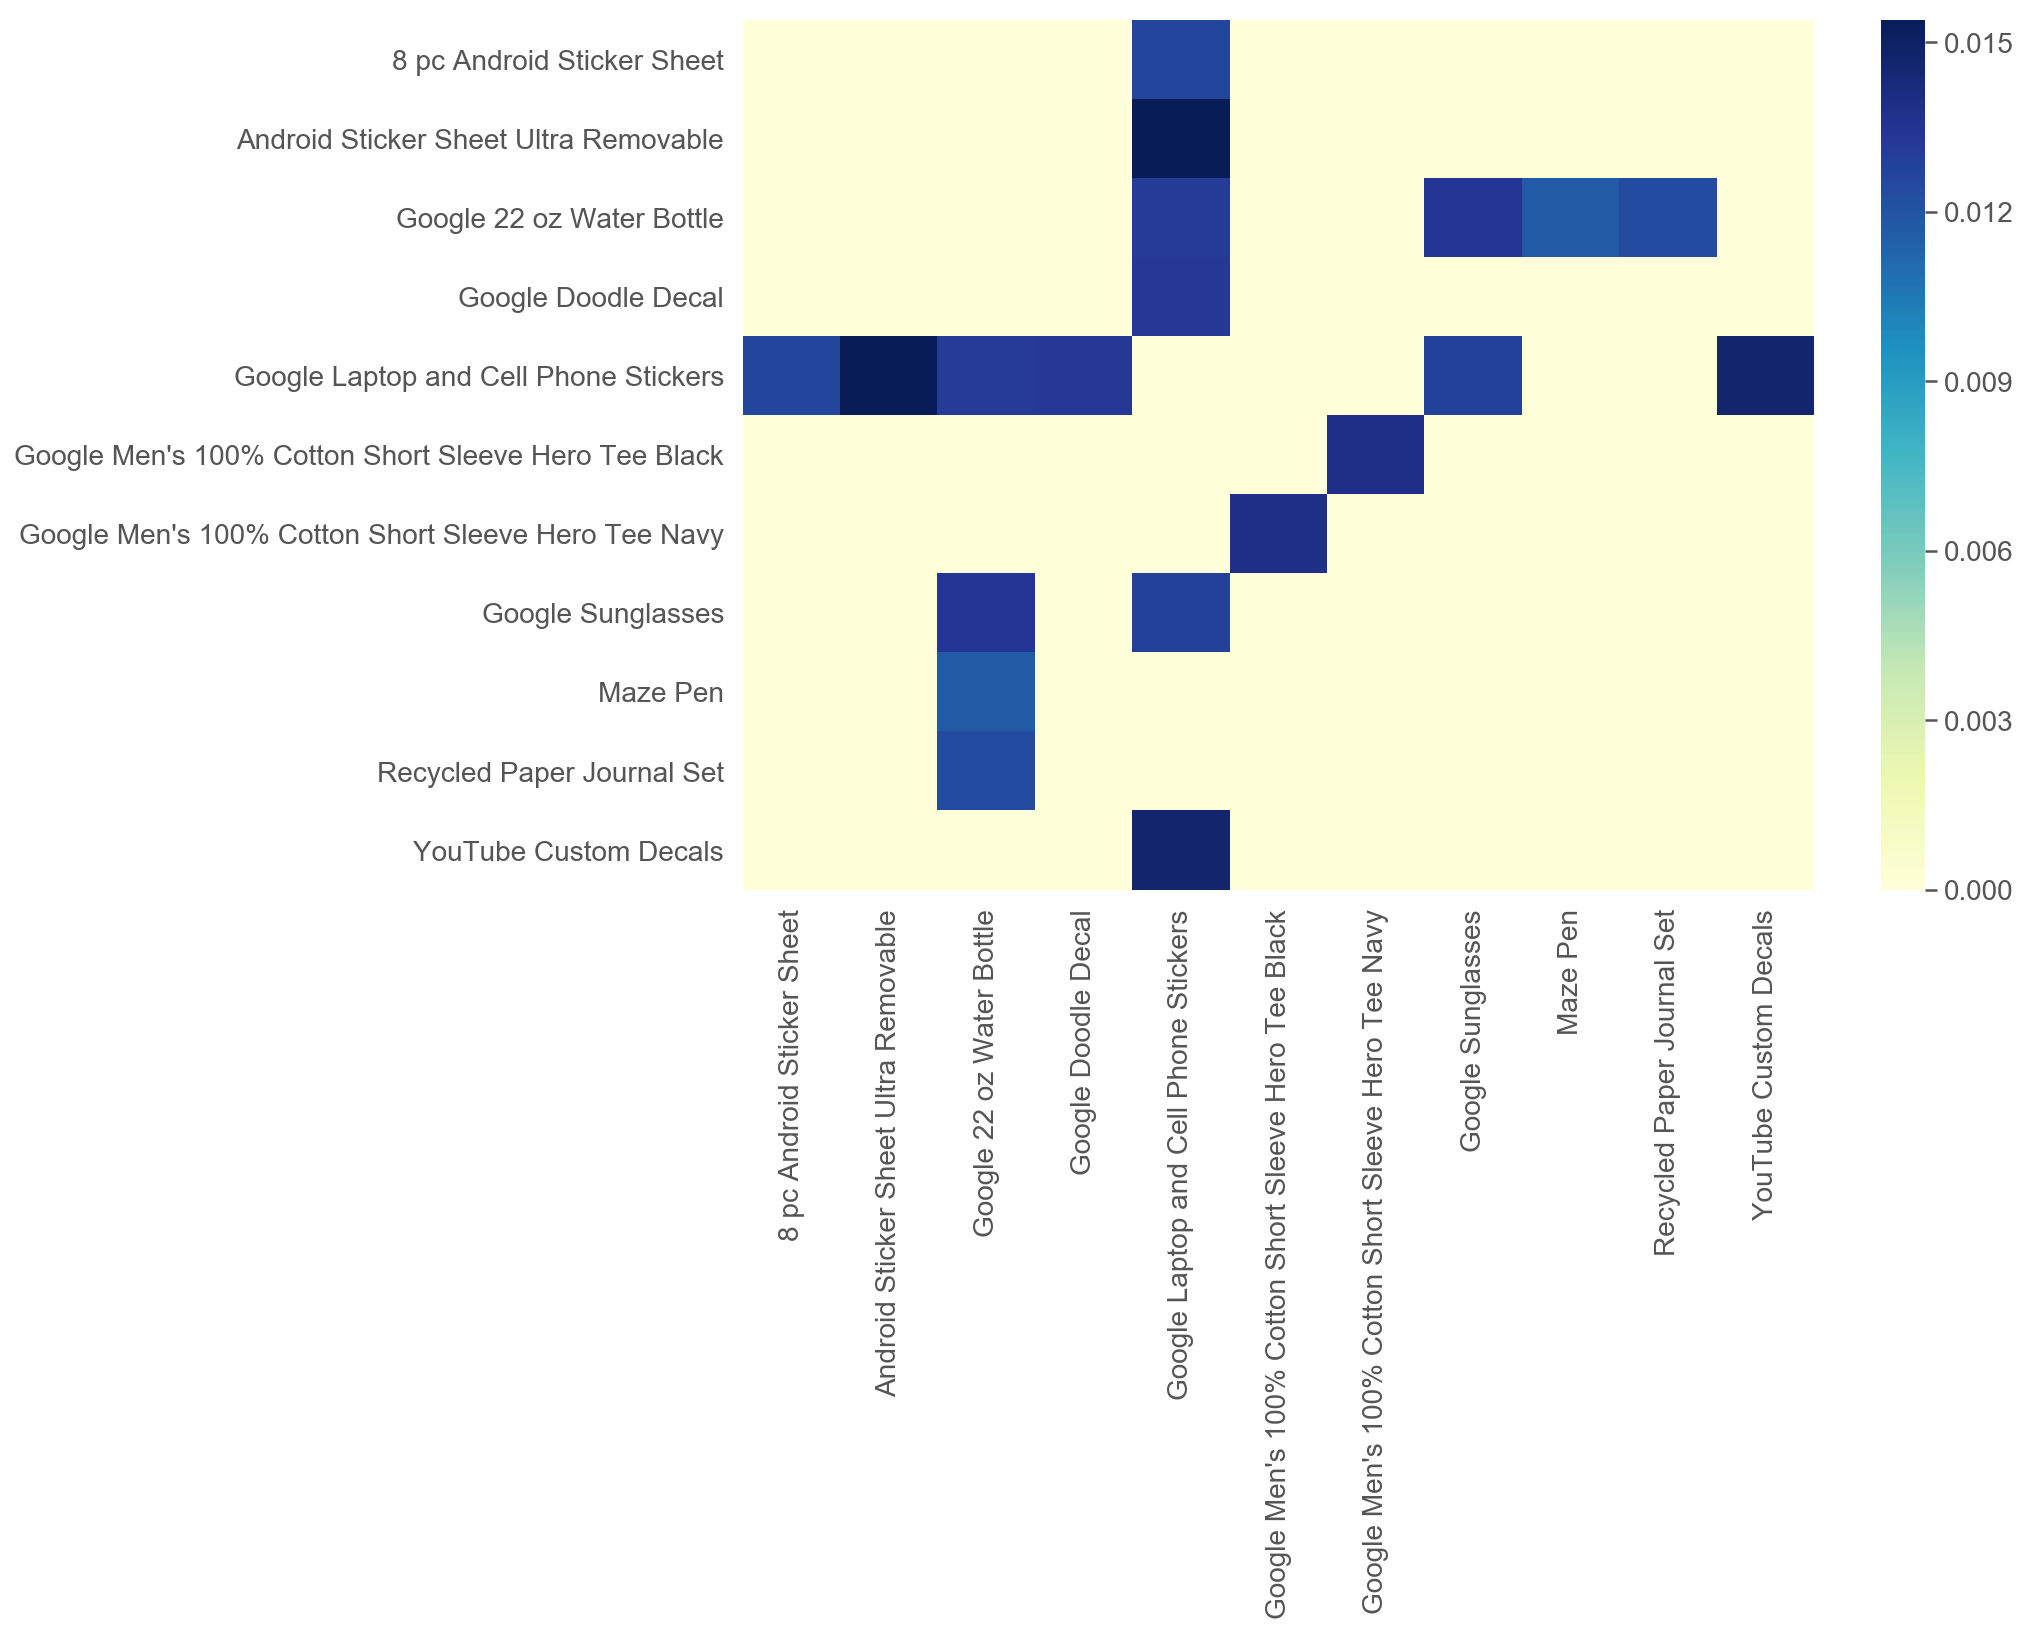

In [46]:
most_frequent_itemsets = (frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)]
                     .sort_values('support', ascending=False).head(10))

data_1 = most_frequent_itemsets.copy()
data_2 = most_frequent_itemsets.copy()
data_1['item_1'] = data_1.itemsets.apply(lambda x: list(x)[0])
data_1['item_2'] = data_1.itemsets.apply(lambda x: list(x)[1])
data_2['item_1'] = data_2.itemsets.apply(lambda x: list(x)[1])
data_2['item_2'] = data_2.itemsets.apply(lambda x: list(x)[0])
data = pd.concat((data_1, data_2))

data_zeros = pd.DataFrame([[0, ''] + list(x) for x in combinations(data[['item_1', 'item_2']].values.flatten(), 2)], columns=data.columns)
data = pd.concat((data, data_zeros)).groupby(['item_1', 'item_2']).support.sum().reset_index().pivot('item_1', 'item_2', 'support')

print('Support for top pairs of items:')

sns.heatmap(data, cmap='YlGnBu')
plt.xlabel('')
plt.ylabel('')
savefig('association_rules_frequent_item_combinations_10')

Support for top pairs of items:


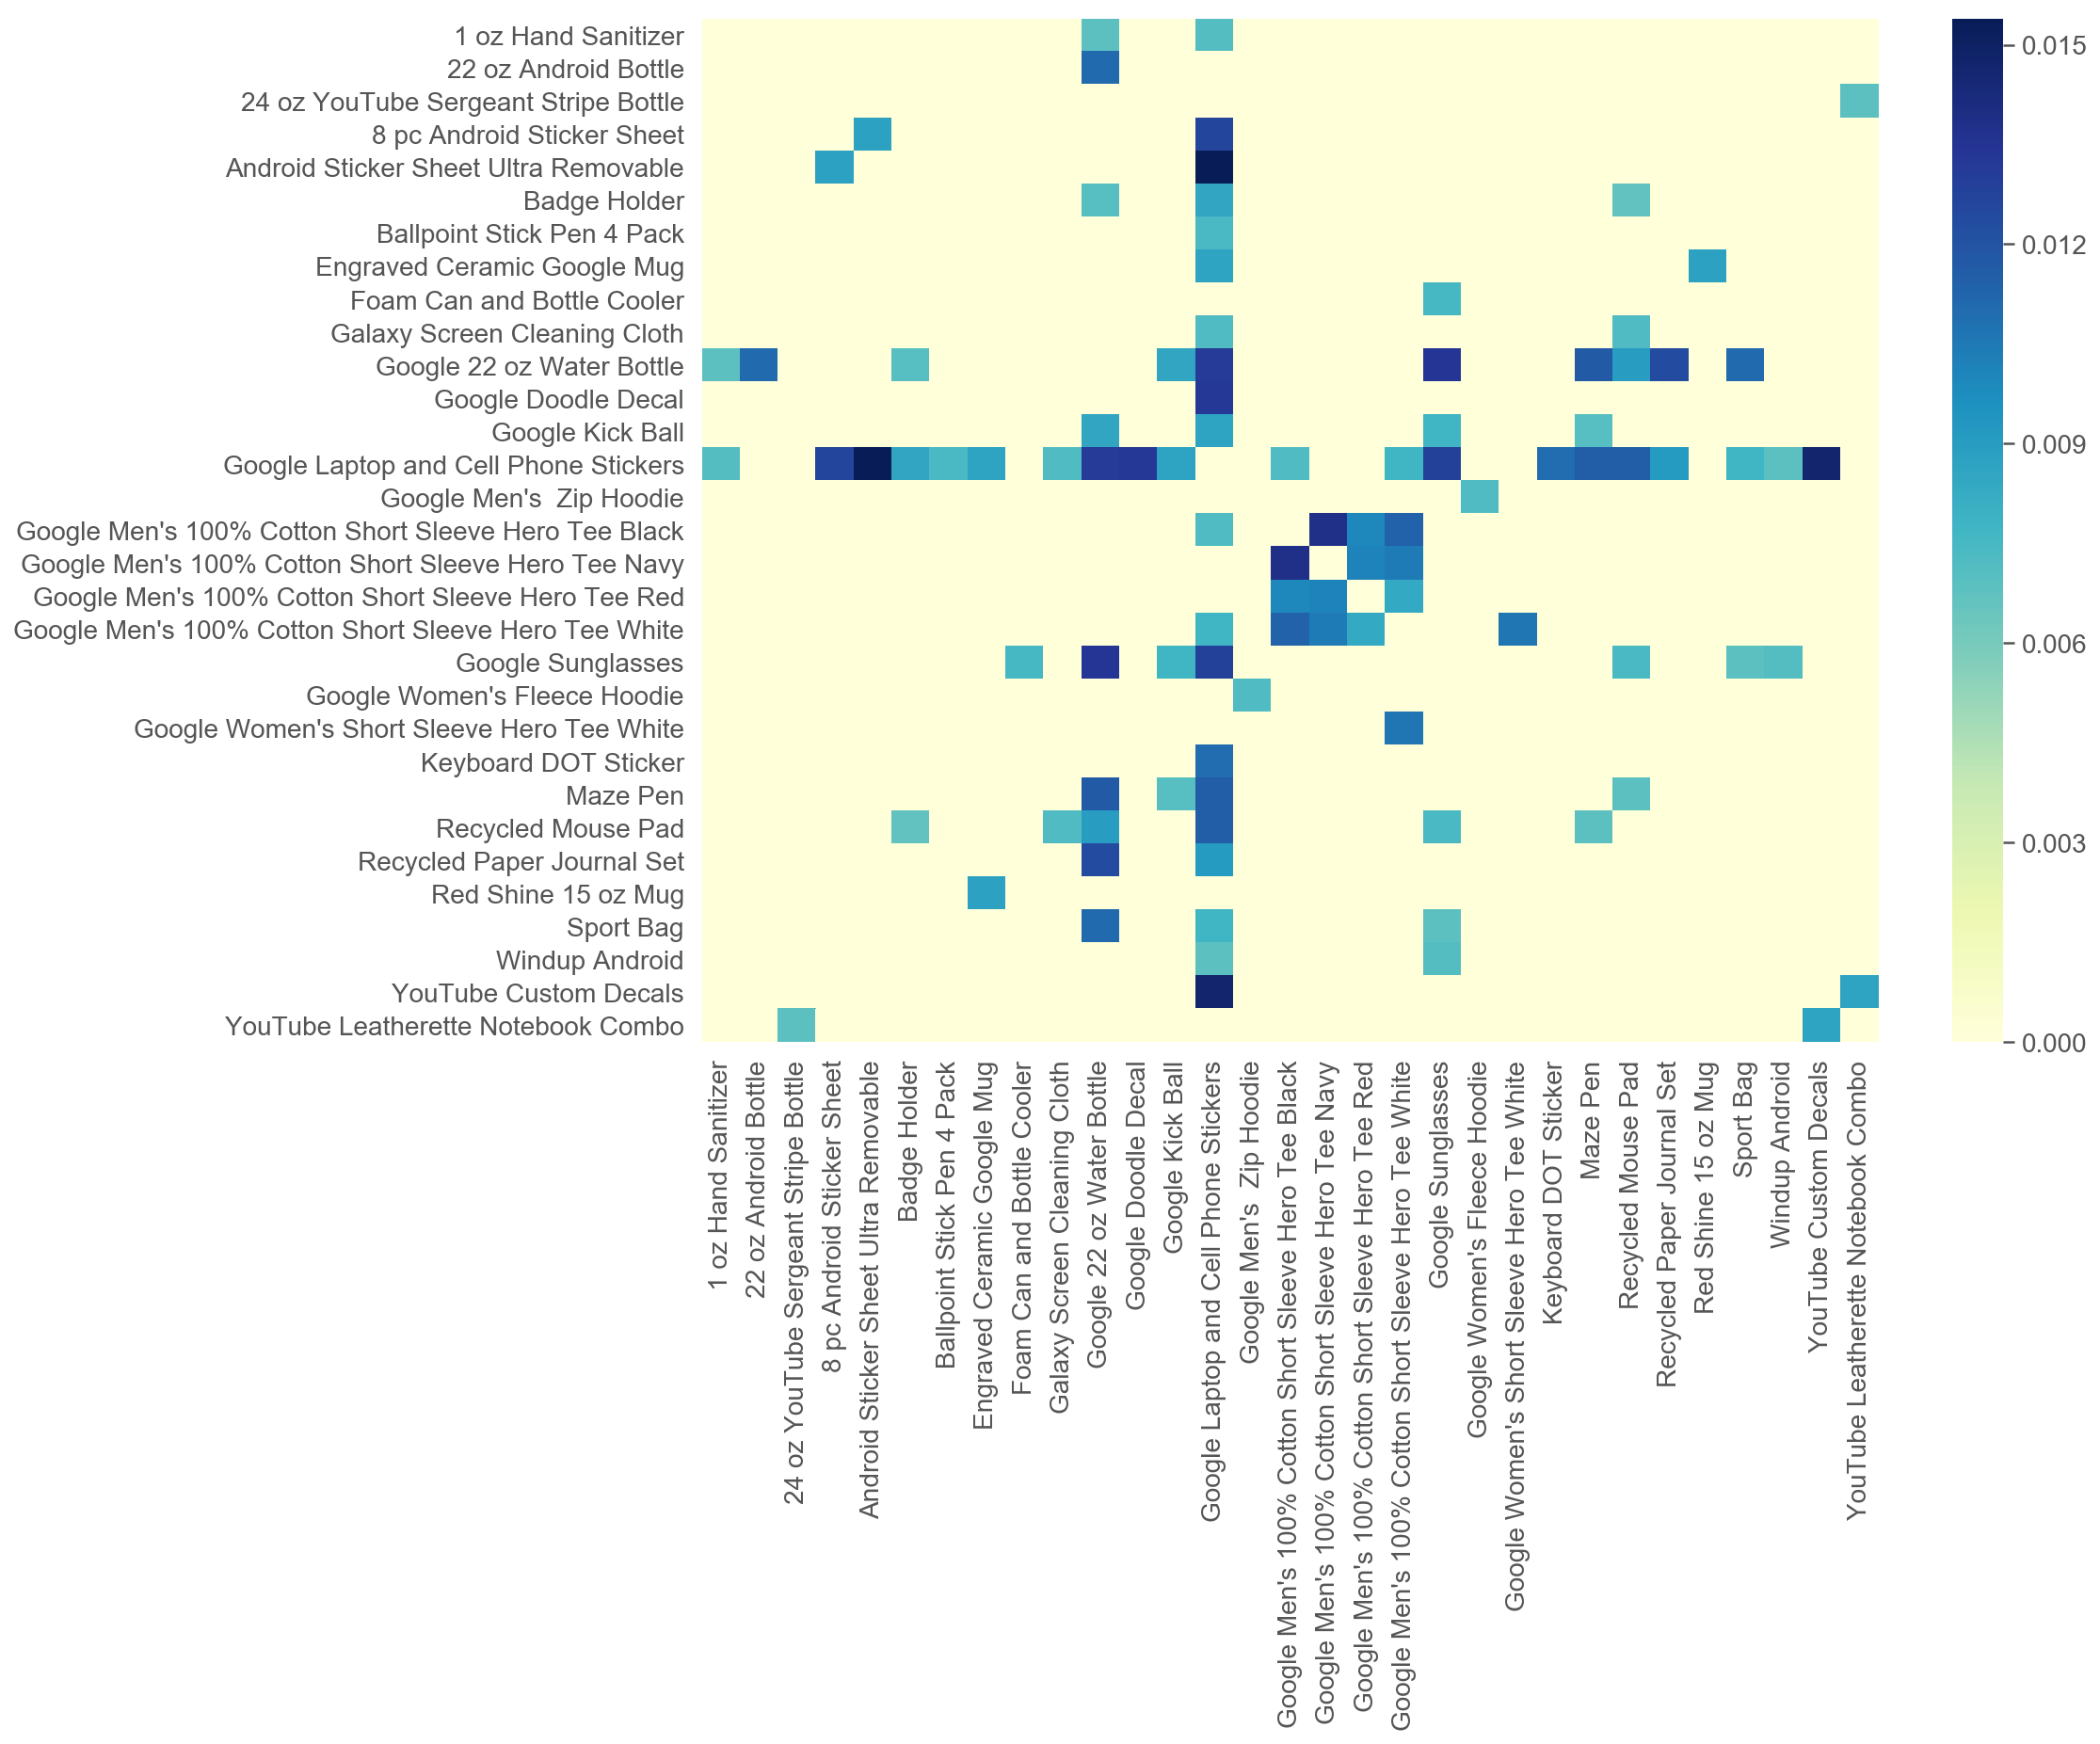

In [47]:
plt.figure(figsize=(14, 10))

most_frequent_itemsets = (frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x) > 1)]
                     .sort_values('support', ascending=False).head(50))

data_1 = most_frequent_itemsets.copy()
data_2 = most_frequent_itemsets.copy()
data_1['item_1'] = data_1.itemsets.apply(lambda x: list(x)[0])
data_1['item_2'] = data_1.itemsets.apply(lambda x: list(x)[1])
data_2['item_1'] = data_2.itemsets.apply(lambda x: list(x)[1])
data_2['item_2'] = data_2.itemsets.apply(lambda x: list(x)[0])
data = pd.concat((data_1, data_2))

data_zeros = pd.DataFrame([[0, ''] + list(x) for x in combinations(data[['item_1', 'item_2']].values.flatten(), 2)], columns=data.columns)
data = pd.concat((data, data_zeros)).groupby(['item_1', 'item_2']).support.sum().reset_index().pivot('item_1', 'item_2', 'support')

print('Support for top pairs of items:')

sns.heatmap(data, cmap='YlGnBu')
plt.xlabel('')
plt.ylabel('')
savefig('association_rules_frequent_item_combinations_50')

In [48]:
rules = association_rules(frequent_itemsets)

In [49]:
rules.sort_values('confidence', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,"(Maze Pen, Android Sticker Sheet Ultra Removable)",(Google Laptop and Cell Phone Stickers),0.002281,0.107326,0.002138,0.9375,8.735060,0.001893,14.282782
2,"(Android Sticker Sheet Ultra Removable, Ballpoint Stick Pen 4 Pack)",(Google Laptop and Cell Phone Stickers),0.001425,0.107326,0.001283,0.9000,8.385657,0.001130,8.926739
15,"(Maze Pen, Sport Bag, Galaxy Screen Cleaning Cloth)",(Google 22 oz Water Bottle),0.001425,0.071978,0.001283,0.9000,12.503762,0.001180,9.280217
14,"(Badge Holder, Maze Pen, Sport Bag)",(Google 22 oz Water Bottle),0.001425,0.071978,0.001283,0.9000,12.503762,0.001180,9.280217
10,"(Recycled Paper Journal Set, Retractable Ballpoint Pen Red)",(Google 22 oz Water Bottle),0.001425,0.071978,0.001283,0.9000,12.503762,0.001180,9.280217


In [50]:
rules.sort_values('antecedent support', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7,"(Android Sticker Sheet Ultra Removable, YouTube Custom Decals)",(Google Laptop and Cell Phone Stickers),0.004561,0.107326,0.003991,0.875000,8.152722,0.003501,7.141391
4,"(Maze Pen, Android Sticker Sheet Ultra Removable)",(Google Laptop and Cell Phone Stickers),0.002281,0.107326,0.002138,0.937500,8.735060,0.001893,14.282782
5,"(Red Shine 15 oz Mug, Android Sticker Sheet Ultra Removable)",(Google Laptop and Cell Phone Stickers),0.002138,0.107326,0.001853,0.866667,8.075077,0.001623,6.695054
6,"(Sport Bag, Android Sticker Sheet Ultra Removable)",(Google Laptop and Cell Phone Stickers),0.001568,0.107326,0.001283,0.818182,7.623325,0.001115,4.909706
0,"(8 pc Android Sticker Sheet, Galaxy Screen Cleaning Cloth)",(Google Laptop and Cell Phone Stickers),0.001425,0.107326,0.001140,0.800000,7.453918,0.000987,4.463369
10,"(Recycled Paper Journal Set, Retractable Ballpoint Pen Red)",(Google 22 oz Water Bottle),0.001425,0.071978,0.001283,0.900000,12.503762,0.001180,9.280217
15,"(Maze Pen, Sport Bag, Galaxy Screen Cleaning Cloth)",(Google 22 oz Water Bottle),0.001425,0.071978,0.001283,0.900000,12.503762,0.001180,9.280217
14,"(Badge Holder, Maze Pen, Sport Bag)",(Google 22 oz Water Bottle),0.001425,0.071978,0.001283,0.900000,12.503762,0.001180,9.280217
12,"(1 oz Hand Sanitizer, Ballpoint Pen Blue, Google Kick Ball)",(Maze Pen),0.001425,0.043615,0.001140,0.800000,18.342484,0.001078,4.781927
11,"(Google Doodle Decal, Google Men's 100% Cotton Short Sleeve Hero Tee White)",(Google Laptop and Cell Phone Stickers),0.001425,0.107326,0.001140,0.800000,7.453918,0.000987,4.463369


In [51]:
rules['rule'] = rules.antecedents.apply(list).astype(str) + '  ->  ' + rules.consequents.apply(list).astype(str)

In [52]:
s = (
    rules.sort_values('support', ascending=False)
         .head(10)[['rule', 'support', 'confidence']]
         .style
)
s.bar(subset=['support', 'confidence'], color='#6670ff')

,rule,support,confidence
7,"['Android Sticker Sheet Ultra Removable', 'YouTube Custom Decals'] -> ['Google Laptop and Cell Phone Stickers']",0.00399088,0.875
4,"['Maze Pen', 'Android Sticker Sheet Ultra Removable'] -> ['Google Laptop and Cell Phone Stickers']",0.00213797,0.9375
5,"['Red Shine 15 oz Mug', 'Android Sticker Sheet Ultra Removable'] -> ['Google Laptop and Cell Phone Stickers']",0.00185291,0.866667
2,"['Android Sticker Sheet Ultra Removable', 'Ballpoint Stick Pen 4 Pack'] -> ['Google Laptop and Cell Phone Stickers']",0.00128278,0.9
15,"['Maze Pen', 'Sport Bag', 'Galaxy Screen Cleaning Cloth'] -> ['Google 22 oz Water Bottle']",0.00128278,0.9
6,"['Sport Bag', 'Android Sticker Sheet Ultra Removable'] -> ['Google Laptop and Cell Phone Stickers']",0.00128278,0.818182
14,"['Badge Holder', 'Maze Pen', 'Sport Bag'] -> ['Google 22 oz Water Bottle']",0.00128278,0.9
10,"['Recycled Paper Journal Set', 'Retractable Ballpoint Pen Red'] -> ['Google 22 oz Water Bottle']",0.00128278,0.9
0,"['8 pc Android Sticker Sheet', 'Galaxy Screen Cleaning Cloth'] -> ['Google Laptop and Cell Phone Stickers']",0.00114025,0.8
12,"['1 oz Hand Sanitizer', 'Ballpoint Pen Blue', 'Google Kick Ball'] -> ['Maze Pen']",0.00114025,0.8


In [ ]:
from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;padding-top:50px;padding-bottom:50px}</style>')